In [168]:
!pip -q install -U transformers accelerate scikit-learn matplotlib

import os, re, time, random, gc, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertConfig, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve)

In [169]:
# ------------------------------------------------------------
# [0] Colab: mount Google Drive
# ------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
# ------------------------------------------------------------
# [1] CONFIG — set your paths
#    Put these three files in Drive and update the paths below.
# ------------------------------------------------------------
CSV_PATH     = "/content/drive/My Drive/DLI Assignment/group_dataset.csv"  # your dataset
VOCAB_TXT    = "/content/drive/My Drive/DLI Assignment/vocab.txt"          # your tokenizer vocab
URLBERT_PT   = "/content/drive/My Drive/DLI Assignment/urlBERT.pt"         # your encoder weights

# Training & model hyperparams
SEED         = 2025
MAX_LEN      = 128
BATCH_SIZE   = 64
EPOCHS       = 3
LR           = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
DROPOUT      = 0.2
KERNEL_SIZES = (2,3,4)
NUM_FILTERS  = 128

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

Device: cuda


In [171]:
# ------------------------------------------------------------
# [2] Reproducibility
# ------------------------------------------------------------
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

In [174]:
# ------------------------------------------------------------
# [3] Load dataset (flexible column detection)  — FIXED
#     (now recognizes 'status' as the label column)
# ------------------------------------------------------------
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"
df = pd.read_csv(CSV_PATH)
print("Loaded CSV columns:", list(df.columns))

URL_CANDS   = ["url","URL","Url","u","link","raw_url","text","domain"]
# Added 'status' variants here:
LABEL_CANDS = ["status","Status","STATUS",
               "label","Label","labels","target","y","class","type","is_phishing","result"]

def pick_col(df, cands):
    cols_lower = {c.lower(): c for c in df.columns}
    for c in cands:
        if c in df.columns: return c
        if c.lower() in cols_lower: return cols_lower[c.lower()]
    raise ValueError(f"Cannot find any of {cands}. Found: {df.columns[:10]} ...")

def normalize_url(u):
    import re
    if not isinstance(u, str): u = str(u)
    u = u.strip().replace("\\","/")
    u = re.sub(r"\s+","", u)
    u = re.sub(r"^https?://", "", u, flags=re.IGNORECASE)
    return u[:2048]

STRING_TO_INT = {
    "phishing":1, "spam":1, "bad":1, "malicious":1, "malware":1, "1":1, "true":1,
    "benign":0, "legitimate":0, "good":0, "clean":0, "safe":0, "0":0, "false":0
}
def to_label(x):
    import numpy as np
    if isinstance(x, (int,np.integer,float,np.floating)):
        return int(x)
    s = str(x).strip().lower()
    if s in STRING_TO_INT: return int(STRING_TO_INT[s])
    # default: anything not clearly benign -> phishing (1)
    return 1 if s not in ("0","benign","legitimate","good","clean","safe","false") else 0

u_col = pick_col(df, URL_CANDS)
y_col = pick_col(df, LABEL_CANDS)   # <- will pick 'status' now

# Keep only URL text + label for this urlBERT+CNN approach
df[u_col] = df[u_col].astype(str).map(normalize_url)
df[y_col] = df[y_col].map(to_label).astype(int)
df = df.dropna(subset=[u_col, y_col]).reset_index(drop=True)

print("Label distribution:\n", df[y_col].value_counts(dropna=False))
print(df[[u_col, y_col]].head(3))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[u_col].values, df[y_col].values,
    test_size=0.20, random_state=SEED, stratify=df[y_col].values
)


Loaded CSV columns: ['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_nullHyperlinks

In [175]:
# ------------------------------------------------------------
# [4] Tokenizer: use YOUR vocab.txt
# ------------------------------------------------------------
assert os.path.exists(VOCAB_TXT), f"vocab.txt not found at {VOCAB_TXT}"
tokenizer = BertTokenizer(vocab_file=VOCAB_TXT, do_lower_case=True, tokenize_chinese_chars=False, strip_accents=False)
VOCAB_SIZE = len(tokenizer)
print("Vocab size:", VOCAB_SIZE)

class UrlDataset(Dataset):
    def __init__(self, txts, labels=None, max_len=MAX_LEN):
        self.txts = list(txts)
        self.labels = None if labels is None else list(labels)
        self.max_len = max_len
    def __len__(self): return len(self.txts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.txts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = UrlDataset(X_train, y_train)
test_ds  = UrlDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Vocab size: 5000


In [177]:
# ------------------------------------------------------------
# [5] CNN head on top of BERT token sequence (urlBERTcnn)
# ------------------------------------------------------------
class UrlBertCNN(nn.Module):
    def __init__(self, encoder, num_labels=2, dropout=DROPOUT,
                 kernel_sizes=KERNEL_SIZES, num_filters=NUM_FILTERS):
        super().__init__()
        self.encoder = encoder
        hidden = encoder.config.hidden_size
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=hidden, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(num_filters * len(kernel_sizes), num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # last_hidden_state: (B, L, H)
        x = out.last_hidden_state.permute(0, 2, 1)         # (B, H, L)
        pooled = []
        for conv in self.convs:
            z = torch.relu(conv(x))                        # (B, C, L')
            z = torch.max(z, dim=2).values                 # global max pool -> (B, C)
            pooled.append(z)
        feat = torch.cat(pooled, dim=1)                    # (B, C * len(k))
        feat = self.dropout(feat)
        logits = self.classifier(feat)                     # (B, num_labels)
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return loss, logits
        return logits

model = UrlBertCNN(encoder=encoder).to(DEVICE)


In [178]:
# ------------------------------------------------------------
# [6] Optimizer & scheduler
# ------------------------------------------------------------
total_steps  = max(1, len(train_loader) * EPOCHS)
warmup_steps = int(total_steps * WARMUP_RATIO)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [179]:
# ------------------------------------------------------------
# [7] Train
# ------------------------------------------------------------
def eval_loader(loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            ids  = batch["input_ids"].to(DEVICE, non_blocking=True)
            attn = batch["attention_mask"].to(DEVICE, non_blocking=True)
            lbls = batch.get("labels")
            if lbls is not None:
                lbls = lbls.to(DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(ids, attn)
            probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.extend(probs.tolist())
            all_preds.extend(preds.tolist())
            if lbls is not None:
                all_labels.extend(lbls.detach().cpu().numpy().tolist())
    return np.array(all_probs), np.array(all_preds), (None if not all_labels else np.array(all_labels))

start = time.time()
best_acc, best_state = -1.0, None

for ep in range(1, EPOCHS+1):
    model.train()
    run_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        ids  = batch["input_ids"].to(DEVICE, non_blocking=True)
        attn = batch["attention_mask"].to(DEVICE, non_blocking=True)
        lbls = batch["labels"].to(DEVICE, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            loss, _ = model(ids, attn, lbls)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        run_loss += loss.item()

    # quick validation on held-out test split
    probs, preds, labels = eval_loader(test_loader)
    acc = accuracy_score(labels, preds)
    print(f"Epoch {ep}/{EPOCHS} | train_loss={run_loss/len(train_loader):.4f} | val_acc={acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_state = {k: v.cpu() for k,v in model.state_dict().items()}

# Load best
if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})

train_time = time.time() - start
print(f"\n[Training time] {train_time:.1f} seconds")


Epoch 1/3 | train_loss=0.5251 | val_acc=0.8023
Epoch 2/3 | train_loss=0.2923 | val_acc=0.8990
Epoch 3/3 | train_loss=0.2256 | val_acc=0.9011

[Training time] 186.0 seconds



=== FINAL TEST METRICS (group_dataset) ===
Acc: 0.901137
AUC: 0.966649
Rec: 0.901137
F1 : 0.901137

Confusion Matrix (labels=[0,1]):
 [[1030  113]
 [ 113 1030]]


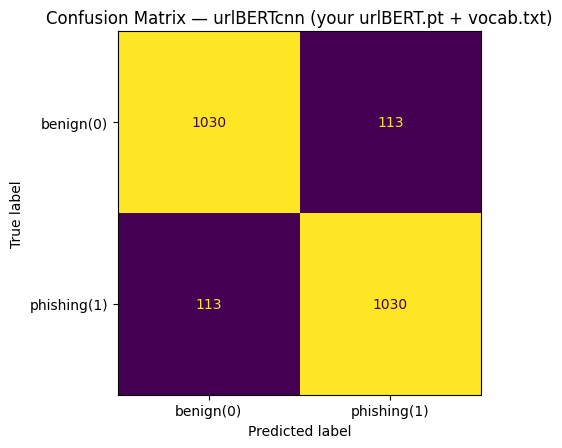

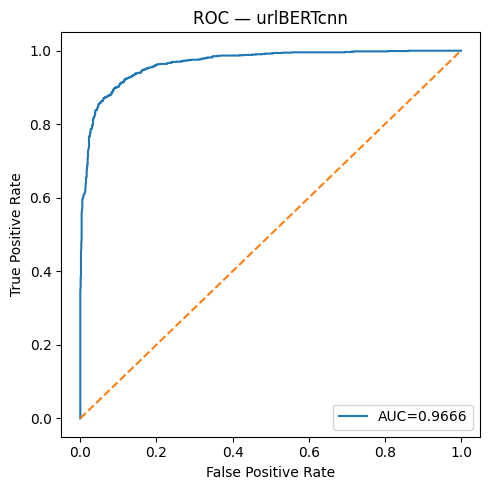

In [180]:
# ------------------------------------------------------------
# [8] Final evaluation
# ------------------------------------------------------------
probs, preds, labels = eval_loader(test_loader)

acc = accuracy_score(labels, preds)
prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
try:
    auc = roc_auc_score(labels, probs)
except Exception:
    auc = float("nan")

print("\n=== FINAL TEST METRICS (group_dataset) ===")
print(f"Acc: {acc:.6f}")
print(f"AUC: {auc:.6f}")
print(f"Rec: {rec:.6f}")
print(f"F1 : {f1:.6f}")

cm = confusion_matrix(labels, preds, labels=[0,1])
print("\nConfusion Matrix (labels=[0,1]):\n", cm)

fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign(0)","phishing(1)"])
disp.plot(ax=ax, values_format="d", colorbar=False)
plt.title("Confusion Matrix — urlBERTcnn (your urlBERT.pt + vocab.txt)")
plt.tight_layout()
plt.show()

try:
    fpr, tpr, thr = roc_curve(labels, probs)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — urlBERTcnn")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
except Exception:
    print("ROC skipped (likely only one class present).")
